(512, 512, 3)
INFO:tensorflow:Restoring parameters from ./pretrained/pretrained_r3d


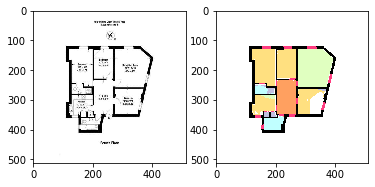

done


In [20]:
import cv2
import os
import argparse
import numpy as np
import tensorflow as tf
import io
import PIL.Image

from scipy.misc import imread, imsave, imresize
from matplotlib import pyplot as plt

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# input image path
parser = argparse.ArgumentParser()

parser.add_argument('--im_path', type=str, default='./demo/47541863.jpg',
                    help='input image paths.')

# color map
floorplan_map = {
    0: [255,255,255], # background
    1: [192,192,224], # closet
    2: [192,255,255], # batchroom/washroom
    3: [224,255,192], # livingroom/kitchen/dining room
    4: [255,224,128], # bedroom
    5: [255,160, 96], # hall
    6: [255,224,224], # balcony
    7: [255,255,255], # not used
    8: [255,255,255], # not used
    9: [255, 60,128], # door & window
    10:[  0,  0,  0]  # wall
}

def ind2rgb(ind_im, color_map=floorplan_map):
    rgb_im = np.zeros((ind_im.shape[0], ind_im.shape[1], 3))

    for i, rgb in color_map.items():
        rgb_im[(ind_im==i)] = rgb

    return rgb_im

def main(args):
    # load input
    im_buf = PIL.Image.open(args.im_path)  
    resize = 512,512
    
    # generating the thumbnail from given size
    im_buf.thumbnail(resize, PIL.Image.ANTIALIAS)

    offset_x = max((resize[0] - im_buf.size[0]) / 2, 0)
    offset_y = max((resize[1] - im_buf.size[1]) / 2, 0)

    offset_tuple = (int(offset_x), int(offset_y)) #pack x and y into a tuple

    # create the image object to be the final product
    im_resized = PIL.Image.new(mode='RGB',size=resize,color=(255, 255, 255))

    # paste the thumbnail into the full sized image
    im_resized.paste(im_buf, offset_tuple)
    
    im = np.array(im_resized) / 255.
    
    print(im.shape)
    
    # create tensorflow session
    with tf.Session() as sess:

        # initialize
        sess.run(tf.group(tf.global_variables_initializer(),
                    tf.local_variables_initializer()))

        # restore pretrained model
        saver = tf.train.import_meta_graph('./pretrained/pretrained_r3d.meta')
        saver.restore(sess, './pretrained/pretrained_r3d')

        # get default graph
        graph = tf.get_default_graph()

        # restore inputs & outpus tensor
        x = graph.get_tensor_by_name('inputs:0')
        room_type_logit = graph.get_tensor_by_name('Cast:0')
        room_boundary_logit = graph.get_tensor_by_name('Cast_1:0')

        # infer results
        [room_type, room_boundary] = sess.run([room_type_logit, room_boundary_logit],\
                                        feed_dict={x:im.reshape(1,512,512,3)})
        room_type, room_boundary = np.squeeze(room_type), np.squeeze(room_boundary)
        
        # merge results
        floorplan = room_type.copy()
        floorplan[room_boundary==1] = 9
        floorplan[room_boundary==2] = 10
        floorplan_rgb = ind2rgb(floorplan)

        # plot results
        plt.subplot(121)
        plt.imshow(im)
        plt.subplot(122)
        plt.imshow(floorplan_rgb/255.)
        plt.show()
        print('done')

if __name__ == '__main__':
    FLAGS, unparsed = parser.parse_known_args()
    main(FLAGS)
